In [1]:
import torch
import torchvision
import os
import glob
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pathway for image folder
imagePath = "/project/trlab/AEImages"
#maskPath = "C:/Users/lskus/OneDrive/Documents/TR Scripts on the go/maskPath"

imagePaths = []
#maskPaths = []
for data_path in glob.glob(imagePath + '/*'):
    imagePaths.append(data_path)
    
#for data_path in glob.glob(maskPath + '/*'):
#    maskPaths.append(data_path)

In [2]:
# Create Dataset class
class Dataset(torch.utils.data.Dataset):
    
    #def __init__(self, imagePaths, maskPaths, transforms, maskTransform):
    def __init__(self, imagePaths):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        #self.transforms = transforms
        
    def transform(self, image):
        # standardize to values between 0 and 1 for faster convergence
        image = image/255.0
        image = image.astype('float32')
        
        # Transform to tensor
        image = TF.to_tensor(image)
        
        # Transfer to device
        image = image.to(device)
        #mask = mask.to(device)
        
        # Random crop
        i, j, h, w = T.RandomCrop.get_params(image, output_size=(512, 512))
        image = TF.crop(image, i, j, h, w)
        #mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            #mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            #mask = TF.vflip(mask)
            
        # Random rotation
        if random.random() > 0.5:
            angle = random.randint(-90,90)
            image = TF.rotate(image,angle)
            #mask = TF.rotate(mask,angle)
            
        # Random Gaussian Blur (can't do on half precision on cpu)
        #if random.random() > 0.5:
        #    image = TF.gaussian_blur(image, 3, 0.1)
        #    mask = TF.gaussian_blur(mask, 3, 0.1)

        return image
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        
        image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        #image = image.astype('float16')
        #image = Image.fromarray(np.uint8(image))
        #image = TF.to_tensor(image)
        
        
        image = self.transform(image)
            
        return image

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.ConvBlock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), #inplace=True can slightly reduce memory usage
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.ConvBlock(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.ConvBlock = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        s = self.ConvBlock(x) #skip connection
        p = self.pool(s) #pass maxpool2d to next layer of network
        return (p, s)
    
#decoder just for autoencoder, change for UNet
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(out_channels, out_channels)

    def forward(self, p):
        x = self.upConv(p)
        return self.ConvBlock(x)
    
#decoder for UNet
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(in_channels, out_channels)

    def forward(self, p, s):
        x = self.upConv(p)
        x = torch.cat([x, s], dim=1)
        return self.ConvBlock(x)

In [4]:
# Model with max pooling layers to match architecture of the UNet
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder1 = EncoderBlock(1, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Decoder
        self.decoder1 = DecoderBlock(1024, 512)
        self.decoder2 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder4 = DecoderBlock(128, 64)
        
        # Final Layer
        self.decoded = nn.Sequential(nn.Conv2d(64, 1, 3, padding=1),
                                     nn.Sigmoid()
                                    )
    def forward(self, x):
        p1, s1 = self.encoder1(x)
        p2, s2 = self.encoder2(p1)
        p3, s3 = self.encoder3(p2)
        p4, s4 = self.encoder4(p3)
        
        b = self.bottleneck(p4)
        
        d1 = self.decoder1(b)
        d2 = self.decoder2(d1)
        d3 = self.decoder3(d2)
        d4 = self.decoder4(d3)
        
        decoded = self.decoded(d4)
        
        return decoded

In [5]:
# not normalizing the dataset
from torchvision import datasets
torch.manual_seed(1)

#transforms = T.Compose([T.ToTensor(),
#                        T.AutoAugment(T.AutoAugmentPolicy.IMAGENET)
#                       ])
#maskTransform = T.ToTensor()

dataset = Dataset(imagePaths = imagePaths
                  #maskPaths = maskPaths,
                  #transforms = transforms,
                  #maskTransform = maskTransform
                 )

#train_size = int(0.9 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 8,
                                     shuffle = True)

In [6]:
#test_dataset.indices

In [7]:
# initialize model
model = AE()
 
# Validation using MSE Loss function
loss_function = nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-4,
                             weight_decay = 1e-8)
model.to(device)

AE(
  (encoder1): EncoderBlock(
    (ConvBlock): ConvBlock(
      (ConvBlock): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): EncoderBlock(
    (ConvBlock): ConvBlock(
      (ConvBlock): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2

In [8]:
# training loop
import matplotlib.pyplot as plt

epochs = 500
count = 1
outputs = []
losses = []
model.train()
for epoch in range(epochs):
    runningLoss = 0
    for (image) in loader:
        
        image = image.to(device)
        
        # Output of Autoencoder
        reconstructed = model(image)
       
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        runningLoss = runningLoss + loss.item()
       
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
    # Storing the losses in a list for plotting
    losses.append(runningLoss/len(loader))
    outputs.append((epochs, image, reconstructed))
    print("epoch", count, "finished")
    count = count + 1

/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished
epoch 50 finished
epoch 51 finished
epoch 52 finished
epoch 53 finished
epoch 54 finished
epoch 55 finished
epoch 56 finished
e

epoch 438 finished
epoch 439 finished
epoch 440 finished
epoch 441 finished
epoch 442 finished
epoch 443 finished
epoch 444 finished
epoch 445 finished
epoch 446 finished
epoch 447 finished
epoch 448 finished
epoch 449 finished
epoch 450 finished
epoch 451 finished
epoch 452 finished
epoch 453 finished
epoch 454 finished
epoch 455 finished
epoch 456 finished
epoch 457 finished
epoch 458 finished
epoch 459 finished
epoch 460 finished
epoch 461 finished
epoch 462 finished
epoch 463 finished
epoch 464 finished
epoch 465 finished
epoch 466 finished
epoch 467 finished
epoch 468 finished
epoch 469 finished
epoch 470 finished
epoch 471 finished
epoch 472 finished
epoch 473 finished
epoch 474 finished
epoch 475 finished
epoch 476 finished
epoch 477 finished
epoch 478 finished
epoch 479 finished
epoch 480 finished
epoch 481 finished
epoch 482 finished
epoch 483 finished
epoch 484 finished
epoch 485 finished
epoch 486 finished
epoch 487 finished
epoch 488 finished
epoch 489 finished
epoch 490 fi

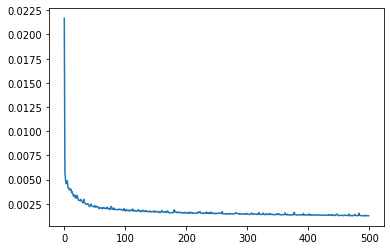

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.arange(epochs),losses)

In [ ]:
#Using aicsimageio to import each frame of the CZI file as a Tiff
from aicsimageio.readers import CziReader
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from aicsimageio.readers import OmeTiffReader
model.eval()
testInput1 = "C:/Users/lskus/OneDrive/Documents/TR Scripts on the go/imagePath/ATP ajusted f1.tif"
#test1 = cv2.imdecode(np.fromfile(testInput1, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
tensorTransform = T.ToTensor()
reader = AICSImage(testInput1)
print(reader.shape)
test1 = reader.get_image_data("YX")
img_tensor = tensorTransform(test1).to('cuda').unsqueeze(0)
output = model(img_tensor)
output = output.squeeze()
#output = output.permute((1,2,0))
output = output.detach().cpu()
plt.imshow(output)

In [ ]:
plt.imshow(test1)

In [10]:
torch.save(model, "/project/trlab/AE_NormalizedImages_04LR.pth")

In [ ]:
model = torch.load("C:/Users/lskus/OneDrive/Documents/TR Scripts on the go/AE4.pth")
model.eval()